In [2]:
import sys
import os
sys.path.append(os.environ["HOME"]+"/.local/lib/python3.9/site-packages")

import scanpy as sc, anndata as ad
import harmonypy
import leidenalg

KeyError: 'HOME'

In [1]:
import os
import scanpy as sc, anndata as ad

In [5]:
%%bash
ls /home/jlyoung/CSE185_Proj/data

  i n d o w s   S u b s y s t e m   f o r   L i n u x   h a s   n o   i n s t a l l e d   d i s t r i b u t i o n s . 
 D i s t r i b u t i o n s   c a n   b e   i n s t a l l e d   b y   v i s i t i n g   t h e   M i c r o s o f t   S t o r e : 
 h t t p s : / / a k a . m s / w s l s t o r e 
 

CalledProcessError: Command 'b'ls /home/jlyoung/CSE185_Proj/data\n'' returned non-zero exit status 1.

In [6]:
DATADIR=os.getcwd()
print(DATADIR)
dsets = ["GSM5114462_S6_B3", "GSM5114465_S7_D25", "GSM5114475_M6_CTRL"]
adatas = {}
for ds in dsets:
    print(ds)
    adatas[ds] = sc.read_10x_mtx(DATADIR, prefix=ds+"_", cache=True)
combined1 = ad.concat(adatas, label="dataset")
combined1.obs_names_make_unique()

c:\Code\CSE_185\CSE185_Proj\benchmark_data
GSM5114462_S6_B3
GSM5114465_S7_D25
GSM5114475_M6_CTRL


C:\Users\lijan\AppData\Roaming\Python\Python311\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
## print dataset dimensions
print(combined)
combined1
#adatas["GSM5114462_S6_B3"]
#adatas["GSM5114465_S7_D25"]
#adatas["GSM5114475_M6_CTRL"]

## print cell info
#combined.obs

AnnData object with n_obs × n_vars = 3948 × 20621
    obs: 'dataset'


AnnData object with n_obs × n_vars = 16849 × 20621
    obs: 'dataset'

In [9]:
# Initial filtering
sc.pp.filter_cells(combined, min_counts=1000)
sc.pp.filter_cells(combined, min_genes=200)
sc.pp.filter_genes(combined, min_counts=15)
sc.pp.filter_genes(combined, min_cells=5)

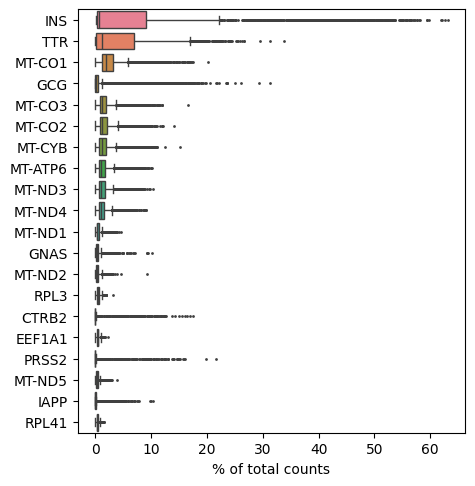

In [10]:
# Filtering cells with high mitochondria gene expression

sc.pl.highest_expr_genes(combined, n_top=20)

In [11]:
# annotate the group of mitochondrial genes as "mt"
combined.var["mt"] = combined.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    combined, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

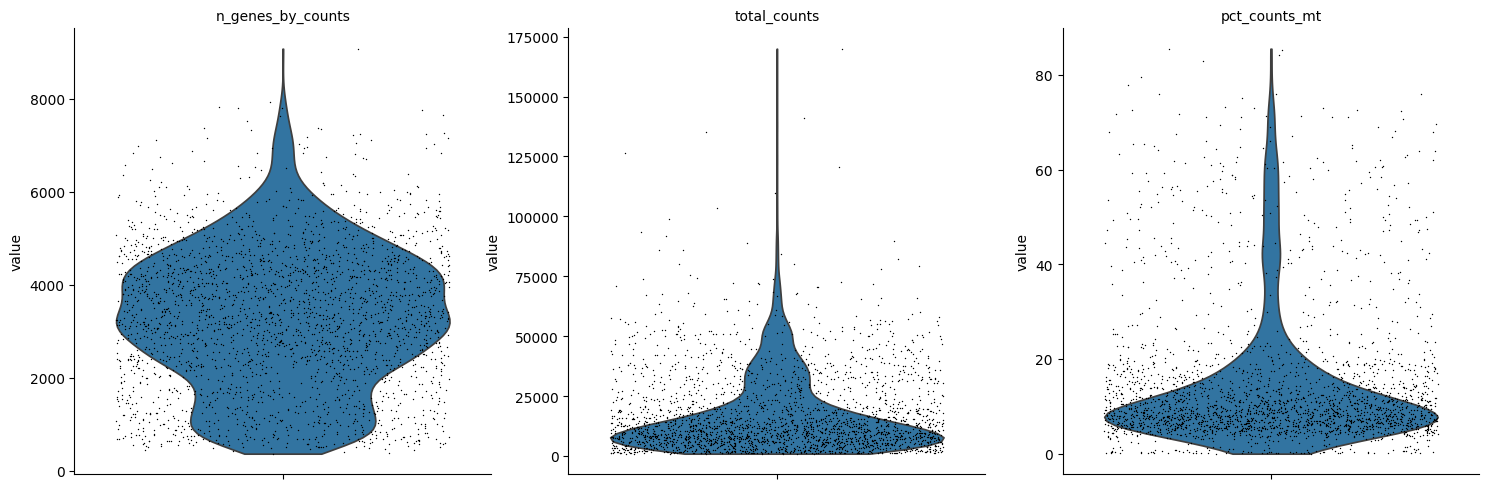

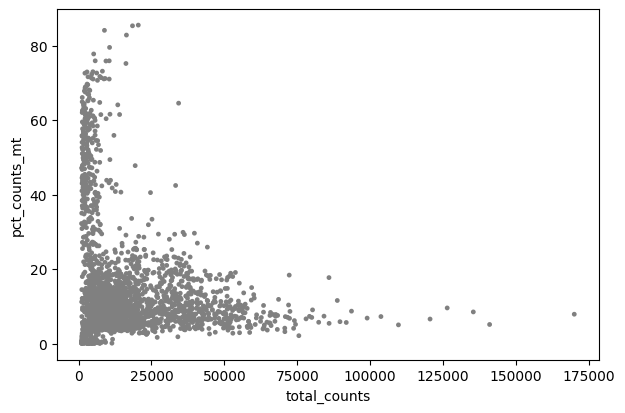

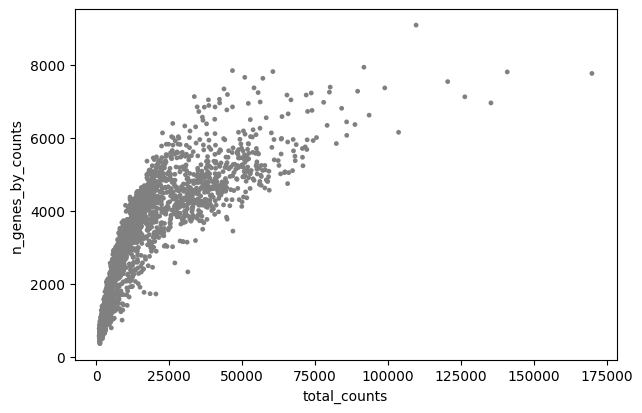

In [12]:
sc.pl.violin(
    combined,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(combined, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(combined, x="total_counts", y="n_genes_by_counts")

In [13]:
adata_filt = combined[(combined.obs["n_genes_by_counts"]<7000) & (combined.obs["pct_counts_mt"]<30), :]

In [14]:
adata_filt
#adata_filt.obs

View of AnnData object with n_obs × n_vars = 2208 × 14617
    obs: 'dataset', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_counts', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

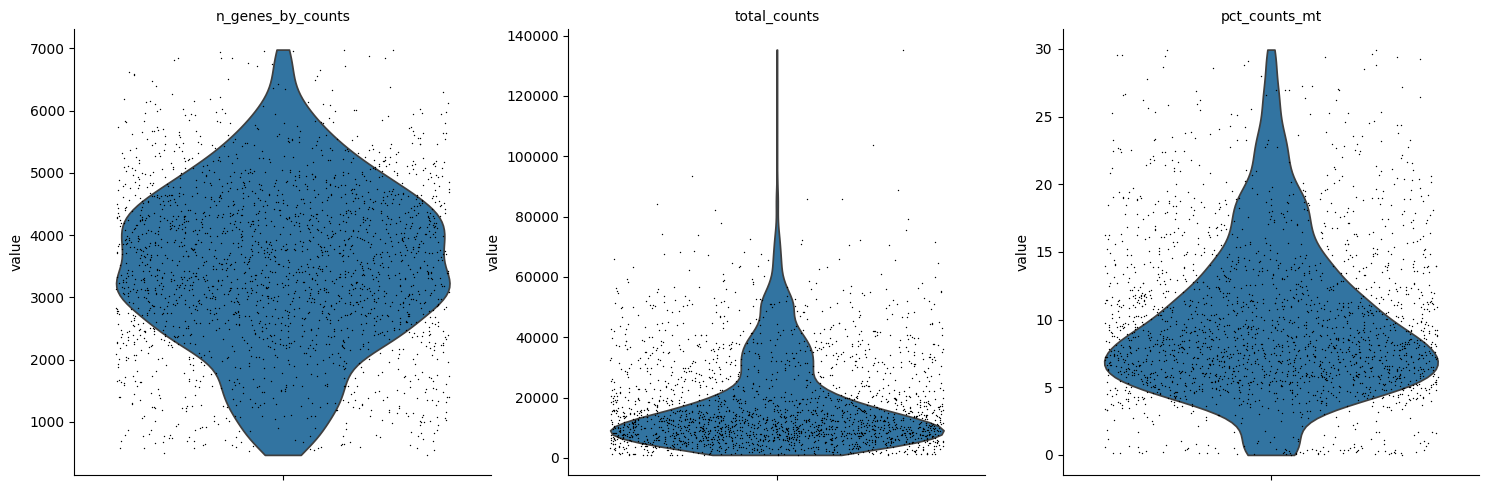

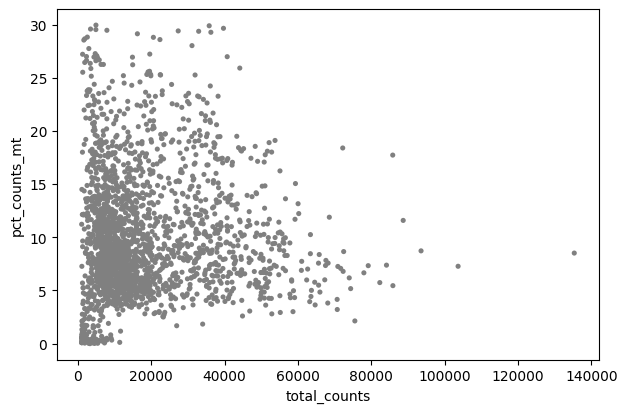

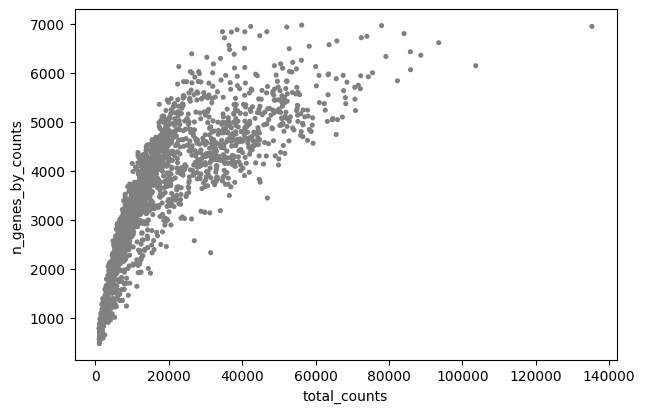

In [15]:
sc.pl.violin(
    adata_filt,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata_filt, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata_filt, x="total_counts", y="n_genes_by_counts")

In [16]:
## Identifying highly variable genes
sc.pp.normalize_per_cell(adata_filt, counts_per_cell_after=1e4) # normalize to 10,000 reads/cell
sc.pp.log1p(adata_filt) # log transform

C:\Users\lijan\AppData\Roaming\Python\Python311\site-packages\scanpy\preprocessing\_simple.py:553: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [24]:
adata_filt.var

,n_counts,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
SAMD11,5518.0,1834,False,1834,0.479910,84.049400,5518.0
NOC2L,4868.0,3518,False,3518,0.423378,69.403374,4868.0
KLHL17,487.0,467,False,467,0.042355,95.938424,487.0
PLEKHN1,57.0,50,False,50,0.004957,99.565142,57.0
HES4,4929.0,2200,False,2200,0.428683,80.866238,4929.0
...,...,...,...,...,...,...,...
AC011043.1,9040.0,5147,False,5147,0.786224,55.235693,9040.0
AC007325.4,3233.0,2384,False,2384,0.281179,79.265959,3233.0
AC007325.2,183.0,173,False,173,0.015916,98.495391,183.0
AC004556.3,17.0,17,False,17,0.001479,99.852148,17.0


In [17]:
sc.pp.highly_variable_genes(adata_filt, batch_key="dataset", n_top_genes=500)

genes = ["GCG", "TTR",  "IAPP",  "GHRL", "PPY", "COL3A1",
    "CPA1", "CLPS", "REG1A", "CTRB1", "CTRB2", "PRSS2", "CPA2", "KRT19", "INS","SST","CELA3A", "VTCN1"]

adata_var = adata_filt[:, (adata_filt.var.index.isin(genes) | adata_filt.var["highly_variable"])]

In [18]:
adata_var

View of AnnData object with n_obs × n_vars = 2208 × 510
    obs: 'dataset', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_counts', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'

In [27]:
num_highly_variable_genes = sum(adata_var.var['highly_variable'])
print("Number of highly variable genes:", num_highly_variable_genes)

sorted_var = adata_var.var.sort_values(by='dispersions_norm', ascending=False)

top_5_variable_genes = sorted_var.head(5)
print("Top 5 most variable genes:")
print(top_5_variable_genes)

Number of highly variable genes: 500
Top 5 most variable genes:
       n_counts  n_cells     mt  n_cells_by_counts  mean_counts  \
GHRL    63040.0     1658  False               1658     5.482693   
PPY     24175.0     1542  False               1542     2.102540   
NTS      7672.0      703  False                703     0.667246   
MT1G     2183.0      207  False                207     0.189859   
ITLN1    3122.0      414  False                414     0.271525   

       pct_dropout_by_counts  total_counts  highly_variable     means  \
GHRL               85.580101       63040.0             True  1.680951   
PPY                86.588972       24175.0             True  1.075275   
NTS                93.885893        7672.0             True  0.381210   
MT1G               98.199687        2183.0             True  0.169612   
ITLN1              96.399374        3122.0             True  0.261888   

       dispersions  dispersions_norm  highly_variable_nbatches  \
GHRL      7.598976         1

C:\Users\lijan\AppData\Roaming\Python\Python311\site-packages\scanpy\preprocessing\_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


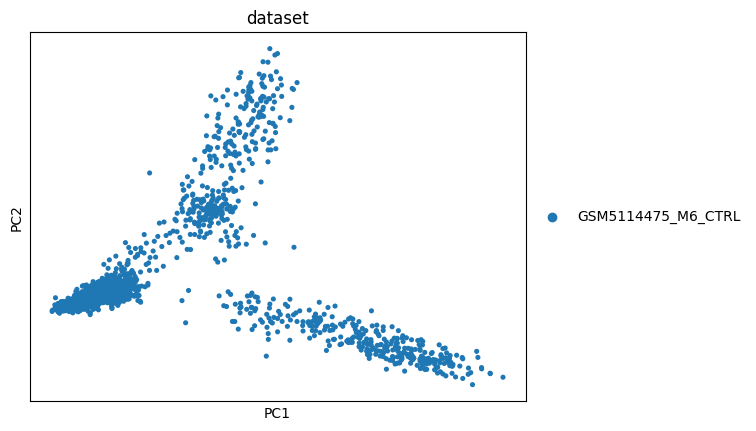

In [19]:
# Removing batch effects

sc.pp.pca(adata_var, n_comps=20)
sc.pl.pca(adata_var, color="dataset")

In [20]:
# Import the "external" library
import scanpy.external as sce

# Run harmony using suggested params from the paper
sce.pp.harmony_integrate(adata_var, 'dataset', theta=2, nclust=50,  max_iter_harmony = 10,  max_iter_kmeans=10)

# Reset the original PCs to those computed by Harmony
adata_var.obsm['X_pca'] = adata_var.obsm['X_pca_harmony']

2024-06-01 09:51:47,304 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-01 09:51:48,547 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-01 09:51:48,569 - harmonypy - INFO - Iteration 1 of 10
2024-06-01 09:51:48,816 - harmonypy - INFO - Iteration 2 of 10
2024-06-01 09:51:49,041 - harmonypy - INFO - Iteration 3 of 10
2024-06-01 09:51:49,273 - harmonypy - INFO - Iteration 4 of 10
2024-06-01 09:51:49,497 - harmonypy - INFO - Iteration 5 of 10
2024-06-01 09:51:49,709 - harmonypy - INFO - Iteration 6 of 10
2024-06-01 09:51:49,919 - harmonypy - INFO - Iteration 7 of 10
2024-06-01 09:51:50,164 - harmonypy - INFO - Iteration 8 of 10
2024-06-01 09:51:50,433 - harmonypy - INFO - Iteration 9 of 10
2024-06-01 09:51:50,661 - harmonypy - INFO - Iteration 10 of 10
2024-06-01 09:51:50,865 - harmonypy - INFO - Stopped before convergence


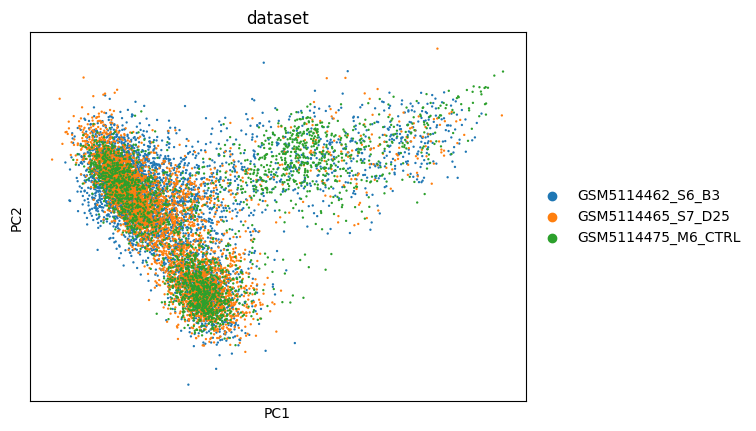

In [29]:
# Plot PCA after batch correction
sc.pl.pca(adata_var, color="dataset")

In [21]:
# Visualizing cell clusters
sc.pp.neighbors(adata_var) # computes neighborhood graphs. Needed to run clustering.
sc.tl.leiden(adata_var) # clusters cells based on expression profiles. This is needed to color cells by cluster.

C:\Users\lijan\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lijan\AppData\Local\Temp\ipykernel_24476\3782316671.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_var) # clusters cells based on expression profiles. This is needed to color cells by cluster.


In [22]:
adata_var.write_h5ad("benchmark_data_small.h5ad")

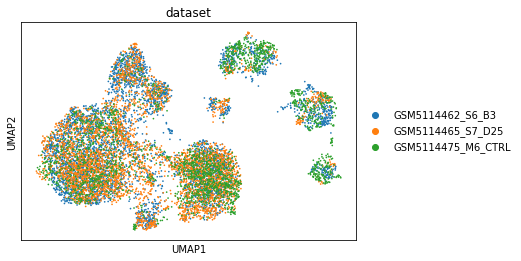

In [34]:
# UMAP

sc.tl.umap(adata_var) # compute UMAP embedding
sc.pl.umap(adata_var, color="dataset") # make the UMAP plot

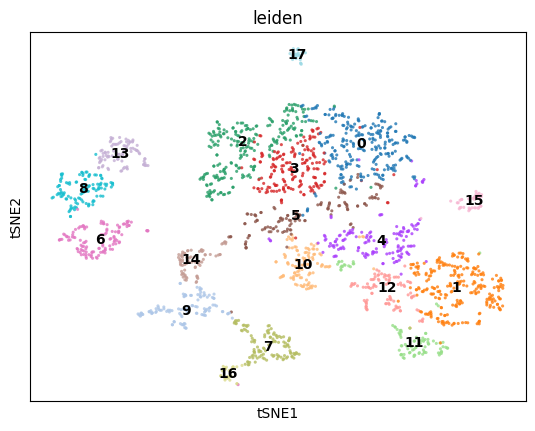

In [23]:
#tSNE

sc.tl.tsne(adata_var, perplexity=10.0)
sc.pl.tsne(adata_var, color=['leiden'], legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20)

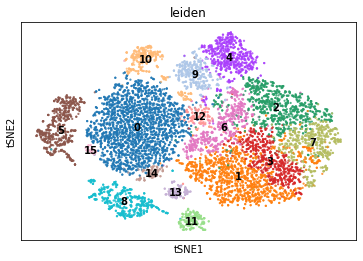

In [40]:
#tSNE

#sc.tl.tsne(adata_var, perplexity=30.0)
sc.pl.tsne(adata_var, color=['leiden'], legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20)

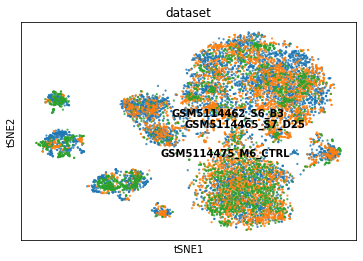

In [37]:
#tSNE

sc.tl.tsne(adata_var, perplexity=50.0)
sc.pl.tsne(adata_var, color=['dataset'], legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20)